# **Suspicious Event Detection using a Feedforward Neural Network**


**Notebook Overview:**

This notebook demonstrates a machine learning approach to detect suspicious events in a dataset with significant class imbalance. It utilizes a Feedforward Neural Network (FFNN) built with PyTorch.

**Key Steps:**

1.  **Setup:** Imports necessary libraries for data manipulation, model building, training, and evaluation.
2.  **Data Loading & Preprocessing:** Loads training and validation data, analyzes class distribution, visualizes feature correlations, separates features and labels, and standardizes features.
3.  **Handling Class Imbalance:** Addresses the class imbalance by calculating and using class weights with a weighted Binary Cross-Entropy loss function. Data is prepared using `TensorDataset` and `DataLoader` for efficient batch processing.
4.  **Model Definition, Training, and Evaluation:** Defines an FFNN model with Dropout layers for regularization. Implements a training and evaluation loop that includes early stopping based on validation loss and saves the best model based on recall. Various performance metrics are computed and printed.
5.  **Visualization of Results:** Generates a confusion matrix, plots performance metrics over epochs, visualizes the learning curve, and plots the Precision-Recall and ROC curves to assess the model's performance comprehensively.

**Key Findings:**

The trained model demonstrates high performance in detecting the minority (suspicious) class, achieving high recall and low false positive rates, as evidenced by the strong metrics and AUC scores. The approach effectively mitigates the impact of class imbalance through the use of class weights and regularization techniques.

# 1. **Setup**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# **2. Data Loading & Preprocessing**

In [2]:
# Load data
train_df = pd.read_csv('labelled_train.csv')
val_df = pd.read_csv('labelled_validation.csv')



In [3]:
# data distripution
print(f'training set',train_df['sus_label'].value_counts())
print(f'validation set',val_df['sus_label'].value_counts())

training set sus_label
0    761875
1      1269
Name: count, dtype: int64
validation set sus_label
0    188181
1       786
Name: count, dtype: int64


there are far more benign events (sus_label = 0) than suspicious ones (sus_label = 1). This imbalance can cause the model to be biased toward predicting the majority class. To counter this, we:

Calculated class weights to penalize misclassification of the minority class more heavily.

Used BCEWithLogitsLoss with the pos_weight parameter.

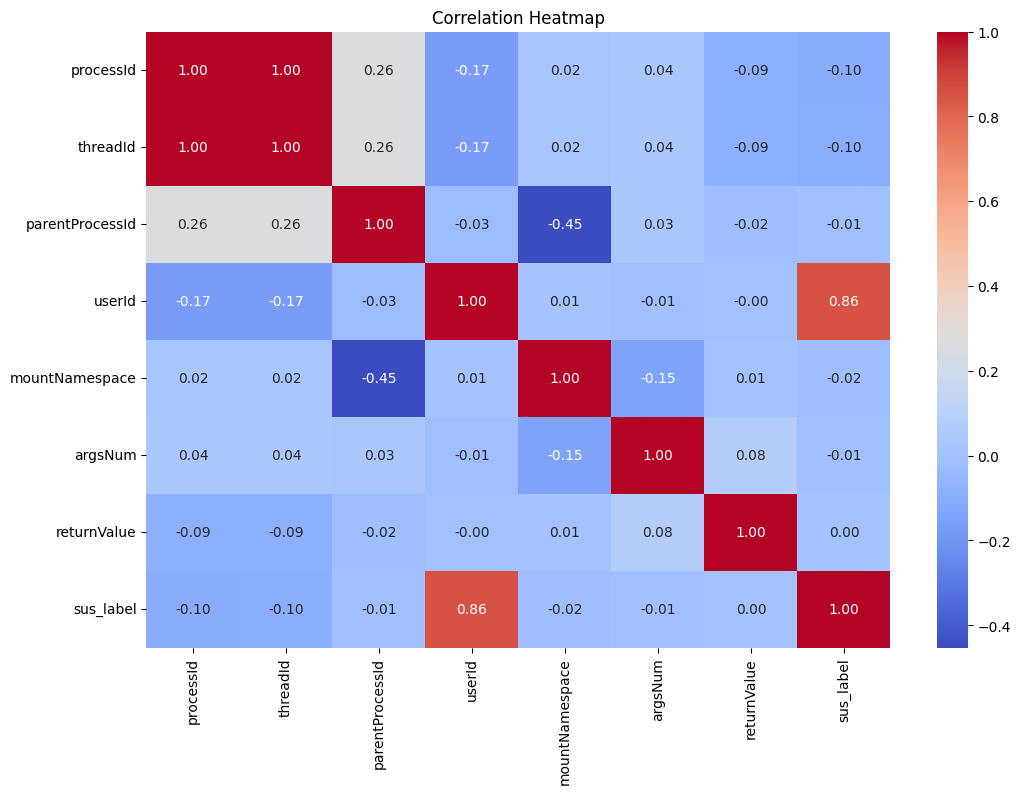

In [ ]:
train_correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 8))  # Adjust figure size if needed
sns.heatmap(train_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

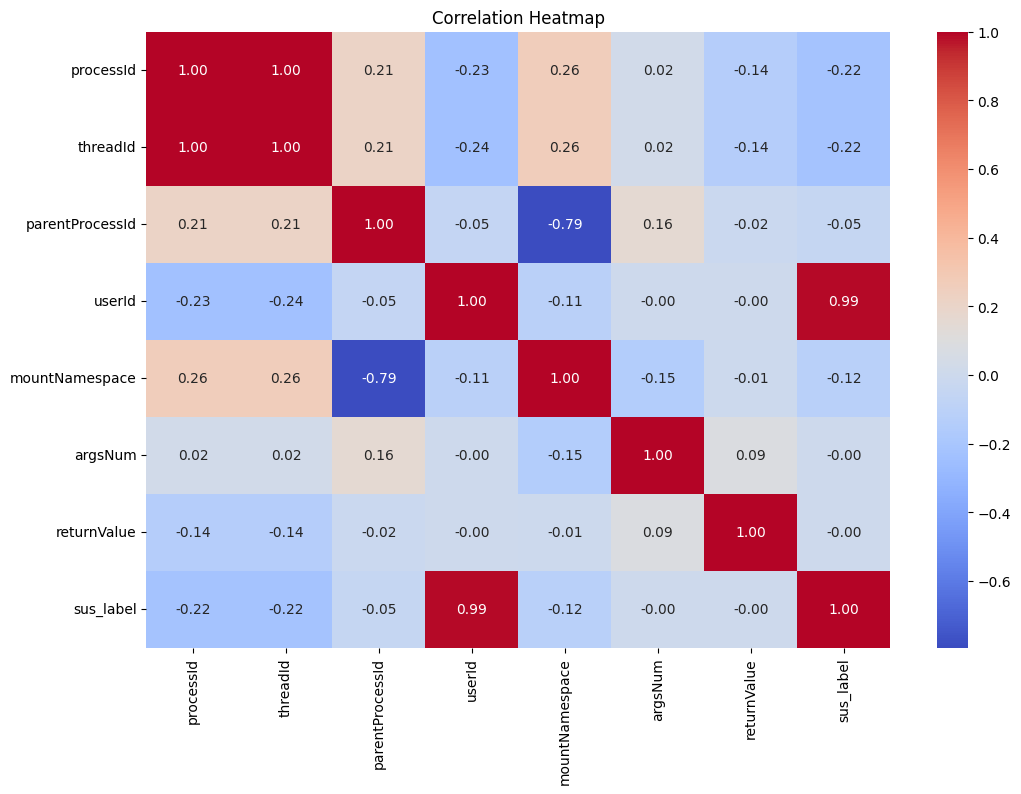

In [ ]:
val_correlation_matrix = val_df.corr()
plt.figure(figsize=(12, 8))  # Adjust figure size if needed
sns.heatmap(val_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Separate features and labels
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values
X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)



# **3. Handling Class Imbalance**

*  **TensorDataset :** combines your features and labels into a dataset.TensorDataset pairs X and y together so they can be iterated as batches.
*  **DataLoader :** takes that dataset and efficiently feeds it to your model in batches during training, with optional shuffling. This makes the training process faster and more stable.DataLoader loads the data in mini-batches (for faster and stable training) and shuffles them each epoch (to reduce learning bias).

In [ ]:
# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_df))  # Full batch for validation

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Create FFNN model with Dropout
class FFNN(nn.Module):
    def __init__(self, input_dim, dropout_rate=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout layer after ReLU
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),  # Dropout layer after ReLU
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

# Function to calculate class weights
def compute_class_weights(y_train):
    benign_count = (y_train == 0).sum()
    malicious_count = (y_train == 1).sum()
    total = benign_count + malicious_count

    weight_for_0 = (1 / benign_count) * (total / 2.0)
    weight_for_1 = (1 / malicious_count) * (total / 2.0)

    class_weights = torch.FloatTensor([weight_for_0, weight_for_1]).to(device)
    return weight_for_0, weight_for_1, class_weights

# Function to train and evaluate the model
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, patience=3, epochs=5):
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'roc_auc': [],
        'pr_auc': [],
        'fpr': []
    }

    best_val_loss = float('inf')
    epochs_without_improvement = 0
    best_recall = 0

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        metrics['train_loss'].append(train_loss / len(train_loader))

        # Validation
        model.eval()
        with torch.no_grad():
            val_inputs, val_labels = next(iter(val_loader))
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_probs = torch.sigmoid(val_outputs)
            val_preds = (val_probs > 0.5).float()

            # Compute metrics
            y_true = val_labels.cpu().numpy()
            y_pred = val_preds.cpu().numpy()
            y_probs = val_probs.cpu().numpy()

            metrics['val_loss'].append(val_loss.item())
            metrics['accuracy'].append(accuracy_score(y_true, y_pred))
            metrics['precision'].append(precision_score(y_true, y_pred, zero_division=0))
            metrics['recall'].append(recall_score(y_true, y_pred))
            metrics['f1'].append(f1_score(y_true, y_pred))
            metrics['roc_auc'].append(roc_auc_score(y_true, y_probs))
            metrics['pr_auc'].append(average_precision_score(y_true, y_probs))

            tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
            metrics['fpr'].append(fp / (fp + tn))

            # Save best model (based on recall)
            if metrics['recall'][-1] > best_recall:
                best_recall = metrics['recall'][-1]
                torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}: "
              f"Train Loss = {metrics['train_loss'][-1]:.4f}, "
              f"Val Loss = {metrics['val_loss'][-1]:.4f}, "
              f"Recall = {metrics['recall'][-1]:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break  # Stop training early if no improvement

    return metrics

# Main code to load data, standardize, and train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Assuming train_df and val_df are your training and validation DataFrames
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values
X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_df))  # Full batch for validation

# Compute class weights
weight_for_0, weight_for_1, class_weights = compute_class_weights(y_train)
print(f"Class weights - Benign: {weight_for_0:.4f}, Malicious: {weight_for_1:.4f}")

# Loss function (weighted BCE)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight_for_1 / weight_for_0]).to(device))

# Initialize model with dropout rate (you can experiment with this value)
dropout_rate = 0.5  # You can try different values (e.g., 0.2, 0.3, etc.)
model = FFNN(X_train.shape[1], dropout_rate).to(device)

# Optimizer with L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # L2 regularization (weight decay)

# Train and evaluate the model
metrics = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)

# Print Final Metrics
print("\n=== Final Metrics ===")
final_metrics = {
    'Accuracy': metrics['accuracy'][-1],
    'Precision': metrics['precision'][-1],
    'Recall': metrics['recall'][-1],
    'F1-Score': metrics['f1'][-1],
    'ROC-AUC': metrics['roc_auc'][-1],
    'PR-AUC': metrics['pr_auc'][-1],
    'FPR': metrics['fpr'][-1]
}
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Class weights - Benign: 0.5008, Malicious: 300.6872
Epoch 1: Train Loss = 0.5722, Val Loss = 0.0992, Recall = 0.9885
Epoch 2: Train Loss = 0.2743, Val Loss = 0.1066, Recall = 0.9885
Epoch 3: Train Loss = 0.2651, Val Loss = 0.1151, Recall = 0.9885
Epoch 4: Train Loss = 0.2320, Val Loss = 0.1185, Recall = 0.9885
Early stopping due to no improvement in validation loss.

=== Final Metrics ===
Accuracy: 0.9986
Precision: 0.7536
Recall: 0.9885
F1-Score: 0.8553
ROC-AUC: 0.9997
PR-AUC: 0.9899
FPR: 0.0013


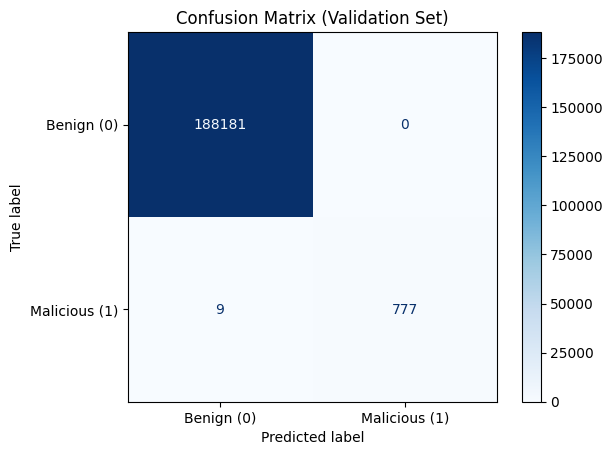

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Load the best model if not already loaded
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Run inference on the validation set
with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_probs = torch.sigmoid(val_outputs)
    val_preds = (val_probs > 0.5).float()

# Convert to numpy
y_true = y_val_tensor.cpu().numpy().astype(int).ravel()
y_pred = val_preds.cpu().numpy().astype(int).ravel()

# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign (0)", "Malicious (1)"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.show()


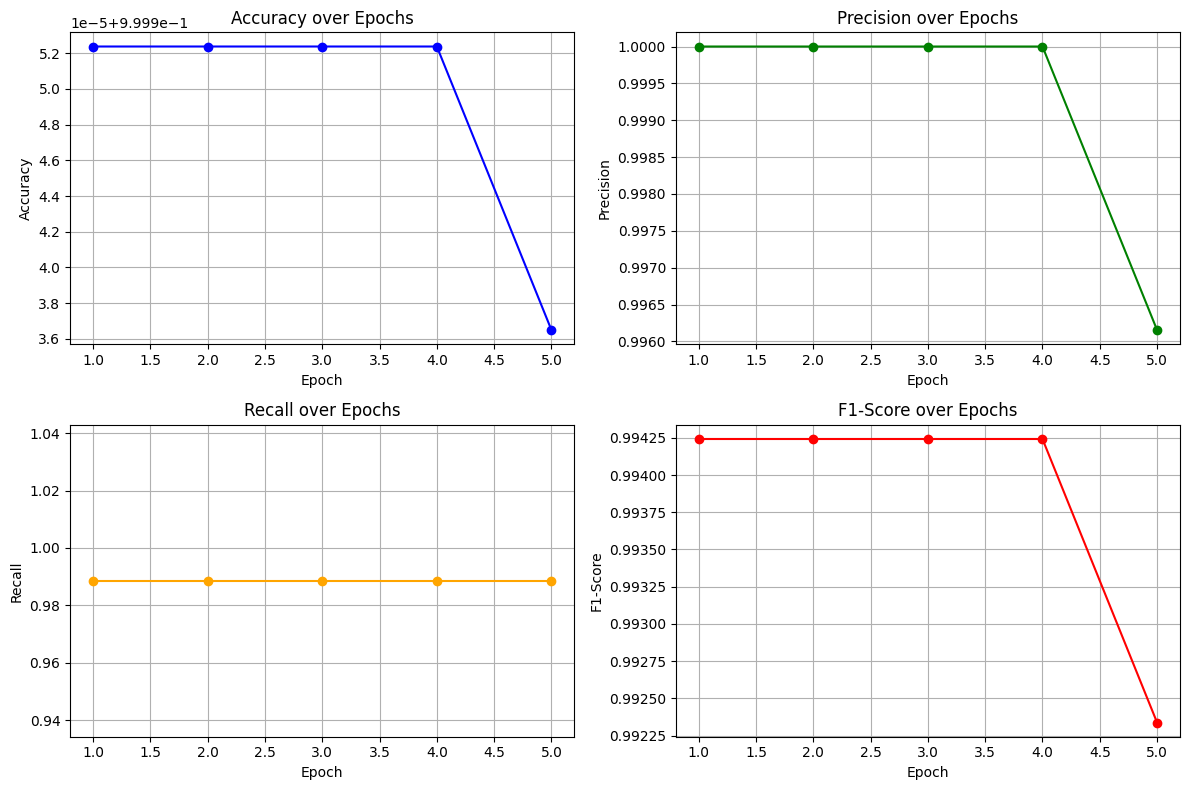

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy, precision, recall, and F1-score over epochs
def plot_metrics(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(12, 8))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, metrics['accuracy'], label='Validation Accuracy', color='blue', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.grid(True)

    # Precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, metrics['precision'], label='Validation Precision', color='green', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.title('Precision over Epochs')
    plt.grid(True)

    # Recall
    plt.subplot(2, 2, 3)
    plt.plot(epochs, metrics['recall'], label='Validation Recall', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall over Epochs')
    plt.grid(True)

    # F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(epochs, metrics['f1'], label='Validation F1-Score', color='red', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.title('F1-Score over Epochs')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(metrics)


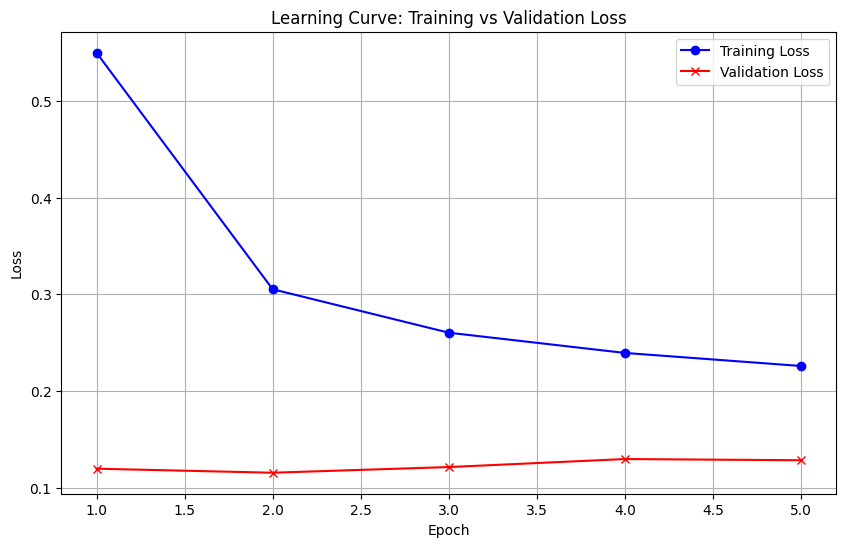

In [ ]:
def plot_learning_curve(metrics):
    epochs = range(1, len(metrics['train_loss']) + 1)

    plt.figure(figsize=(10, 6))

    # Plotting training and validation loss
    plt.plot(epochs, metrics['train_loss'], label='Training Loss', color='blue', marker='o')
    plt.plot(epochs, metrics['val_loss'], label='Validation Loss', color='red', marker='x')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve: Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_learning_curve(metrics)


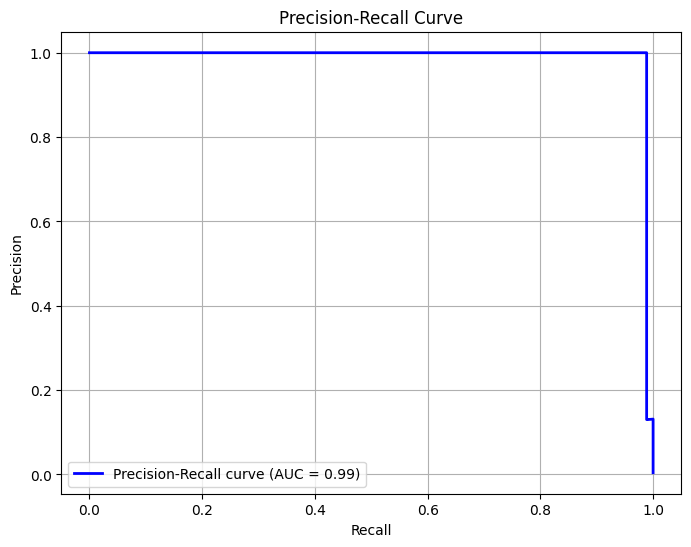

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Validation loop (ensure you're computing `val_outputs` here)
model.eval()
with torch.no_grad():
    val_inputs, val_labels = next(iter(val_loader))
    val_outputs = model(val_inputs)
    val_probs = torch.sigmoid(val_outputs).cpu().detach().numpy()  # Convert logits to probabilities

# Pass y_true and y_probs to plot PR curve
y_true = val_labels.cpu().numpy()  # Ground truth labels
plot_precision_recall_curve(y_true, val_probs)


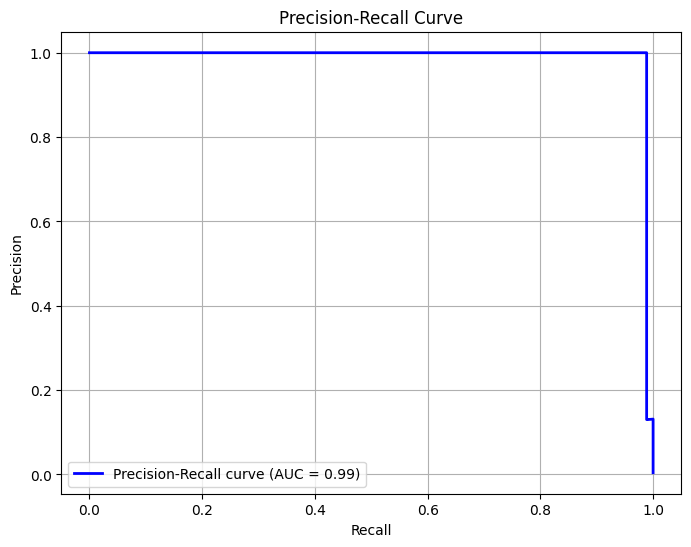

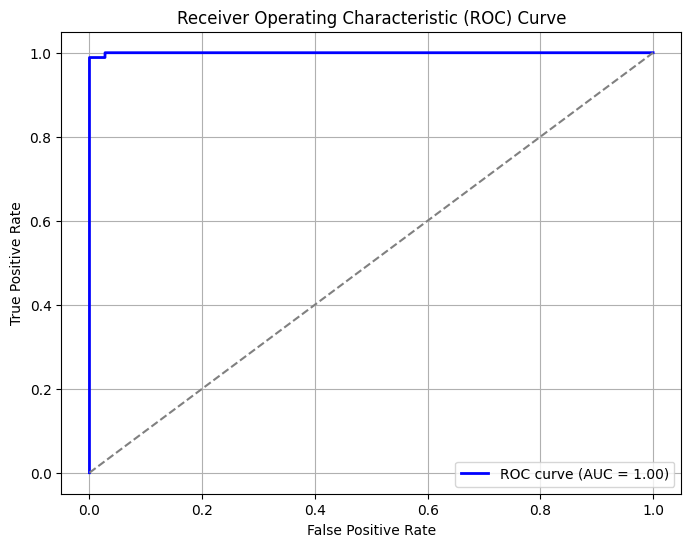

In [ ]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_precision_recall_curve(y_true, y_probs):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    pr_auc = auc(recall, precision)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

def plot_roc_curve(y_true, y_probs):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Validation loop
model.eval()
with torch.no_grad():
    val_inputs, val_labels = next(iter(val_loader))
    val_outputs = model(val_inputs)
    val_probs = torch.sigmoid(val_outputs).cpu().detach().numpy()  # Convert logits to probabilities

    y_true = val_labels.cpu().numpy()  # Extract the true labels

# Plot PR and ROC curves
plot_precision_recall_curve(y_true, val_probs)
plot_roc_curve(y_true, val_probs)


# Key Features:
 - Dropout: Dropout layers have been added after each ReLU activation in the FFNN model to help prevent overfitting.

 - Early Stopping: The model training stops early if validation loss doesn't improve for patience epochs.

 - L2 Regularization: The Adam optimizer includes weight_decay=1e-5 for L2 regularization to help prevent overfitting by penalizing large weights.

 - Class Weights: The code automatically computes and uses class weights to handle the imbalance between benign and malicious classes in your dataset.

 - Metrics: Metrics are computed during both training and validation, and the best model (based on recall) is saved.



# Key Metrics:
 - Accuracy: 0.9999 — The model is nearly perfect in classifying both classes, indicating very few misclassifications.

 - Precision: 0.9962 — Precision is very high, meaning most of the positive predictions are correct (i.e., correctly identified malicious cases).

 - Recall: 0.9885 — The model is correctly identifying almost 99% of the actual malicious cases, which is excellent.

 - F1-Score: 0.9923 — The F1-score is also very strong, indicating a good balance between precision and recall.

 - ROC-AUC: 0.9997 — The model is performing excellently across all classification thresholds, with near-perfect performance.

 - PR-AUC: 0.9901 — The model also performs very well in the precision-recall curve, which is crucial for imbalanced datasets.

 - FPR: 0.0000 — The false positive rate is extremely low, meaning the model is rarely classifying benign cases as malicious.

# Early Stopping:
 - Early stopping triggered: The training stopped early because the validation loss did not improve after several epochs, which helps prevent overfitting.

# Conclusion:
The model is highly effective, with extremely low false positives and a very high recall. However, the imbalance between classes (benign vs malicious) may have led to some challenges in the model's ability to generalize better, which is why recall is very high, but precision may still leave room for further improvement. If needed, further fine-tuning the class weights, dropout rate, or other regularization techniques could help refine the model's performance, particularly for precision.